# 🧠 CIFAR-10 이미지 분류기 (PyTorch)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋 불러오기
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

classes = trainset.classes


100%|██████████| 170M/170M [00:02<00:00, 60.4MB/s]


In [2]:
# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


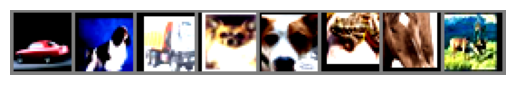

automobile dog truck dog dog frog horse deer


In [3]:
# 데이터 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [ ]:
# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

In [5]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[60, 120],  # 에폭 몇에서 LR 줄일지
    gamma=0.2                   # 줄이는 비율
)

In [ ]:
# 학습
EPOCHS = 150
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1, Loss: 1.7357, LR: 0.100000
Epoch 2, Loss: 1.4091, LR: 0.100000
Epoch 3, Loss: 1.2708, LR: 0.100000
Epoch 4, Loss: 1.1938, LR: 0.100000
Epoch 5, Loss: 1.1644, LR: 0.100000
Epoch 6, Loss: 1.1280, LR: 0.100000
Epoch 7, Loss: 1.1119, LR: 0.100000
Epoch 8, Loss: 1.0707, LR: 0.100000
Epoch 9, Loss: 1.0476, LR: 0.100000
Epoch 10, Loss: 1.0317, LR: 0.100000
Epoch 11, Loss: 1.0200, LR: 0.100000
Epoch 12, Loss: 1.0101, LR: 0.100000
Epoch 13, Loss: 1.0062, LR: 0.100000
Epoch 14, Loss: 0.9974, LR: 0.100000
Epoch 15, Loss: 0.9859, LR: 0.100000
Epoch 16, Loss: 0.9816, LR: 0.100000
Epoch 17, Loss: 0.9773, LR: 0.100000
Epoch 18, Loss: 0.9697, LR: 0.100000
Epoch 19, Loss: 0.9593, LR: 0.100000
Epoch 20, Loss: 0.9588, LR: 0.100000
Epoch 21, Loss: 0.9600, LR: 0.100000
Epoch 22, Loss: 0.9542, LR: 0.100000
Epoch 23, Loss: 0.9610, LR: 0.100000
Epoch 24, Loss: 0.9552, LR: 0.100000
Epoch 25, Loss: 0.9701, LR: 0.100000
Epoch 26, Loss: 0.9444, LR: 0.100000
Epoch 27, Loss: 0.9431, LR: 0.100000
Epoch 28, 

In [7]:
# 정확도 측정
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f' Test Accuracy: {100 * correct / total:.2f}%')

 Test Accuracy: 84.49%


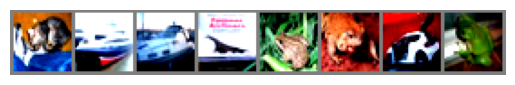

GroundTruth: cat ship ship airplane frog frog automobile frog
Predicted  : cat ship ship airplane frog frog automobile frog


In [8]:
# 예측 결과 시각화
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(8)))
print('Predicted  :', ' '.join(classes[predicted[j]] for j in range(8)))